In [348]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn import metrics 
from scipy.stats import boxcox
from scipy.stats import skew
from sklearn.metrics import roc_curve, auc

In [349]:
import warnings
warnings.filterwarnings('ignore')

In [350]:
df=pd.read_csv('training_dataset.csv')
df1=pd.read_csv('testing_dataset.csv')

In [351]:
df = df.apply(lambda x: np.where(x <= -1, 0, x))
df1 = df1.apply(lambda x: np.where(x <= -1, 0, x))

In [352]:
df= pd.concat([df, df1], axis=0)

In [353]:
df=df.fillna(0)

In [354]:
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1.0,2.0,0.0,892.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,0,1,3,0,3,0,2,0,0,...,1.0,2.0,1.0,9540.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,0,0,1,0,0,0,0,0,0,...,1.0,2.0,3.0,589.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,0,2,5,0,0,0,0,0,0,...,1.0,2.0,0.0,292.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2,0,0,0,0,0,0,0,0,0,...,1.0,2.0,1.0,3597.0,0.0,1.0,0.0,0.0,0.0,0.0


In [355]:
df.describe(include='all')

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,...,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000
mean,2.191162,0.331517,0.113773,1.282039,0.009516,0.207618,0.021499,0.142253,0.002670,0.000976,...,1.183882,2.770191,1.743256,6193.352623,0.505138,0.419398,0.002332,0.003050,0.005409,0.345940
std,1.232098,1.125425,0.653460,1.893424,0.115572,0.964161,0.238095,0.930192,0.076034,0.067482,...,0.790269,1.320924,1.707602,11741.868889,0.499977,0.688897,0.048230,0.055143,0.073345,0.475677
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,2057.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.000000,10799.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,23.000000,35.000000,21.000000,44.000000,9.000000,23.000000,43.000000,26.000000,10.000000,9.000000,...,24.000000,20.000000,20.000000,604800.000000,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000


In [356]:
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column < lower_bound) | (column > upper_bound)]

# Detect outliers for each feature
outliers = {}
for feature in df.columns:
    if feature != "phishing":  # Skip the target column
        outliers[feature] = detect_outliers_iqr(df[feature])
        print(f"Outliers in {feature}: {len(outliers[feature])}")

Outliers in qty_dot_url: 29069
Outliers in qty_hyphen_url: 13037
Outliers in qty_underline_url: 4461
Outliers in qty_slash_url: 2903
Outliers in qty_questionmark_url: 631
Outliers in qty_equal_url: 6089
Outliers in qty_at_url: 1427
Outliers in qty_and_url: 3185
Outliers in qty_exclamation_url: 156
Outliers in qty_space_url: 30
Outliers in qty_tilde_url: 180
Outliers in qty_comma_url: 99
Outliers in qty_plus_url: 111
Outliers in qty_asterisk_url: 44
Outliers in qty_hashtag_url: 9
Outliers in qty_dollar_url: 43
Outliers in qty_percent_url: 1282
Outliers in qty_tld_url: 3468
Outliers in length_url: 7324
Outliers in qty_dot_domain: 1518
Outliers in qty_hyphen_domain: 6781
Outliers in qty_underline_domain: 44
Outliers in qty_slash_domain: 0
Outliers in qty_questionmark_domain: 0
Outliers in qty_equal_domain: 0
Outliers in qty_at_domain: 0
Outliers in qty_and_domain: 0
Outliers in qty_exclamation_domain: 0
Outliers in qty_space_domain: 0
Outliers in qty_tilde_domain: 0
Outliers in qty_comma_

In [357]:
def impute_outliers(data, column):
    Q1 = data[column].quantile(0.10)
    Q3 = data[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = data[column].mean()
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median, data[column])
    return data

data=df.copy()
for column in df.columns:
    data = impute_outliers(data, column)

df=data

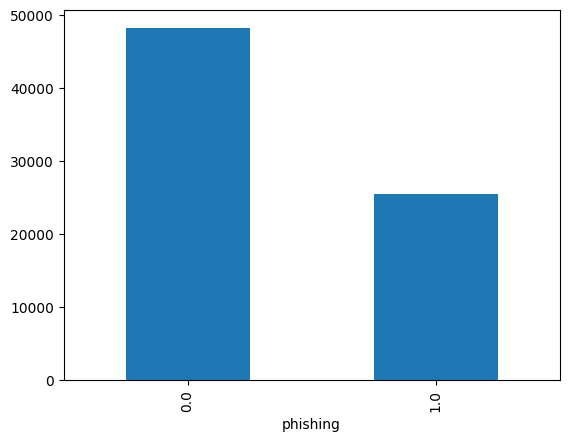

In [358]:
#histogram for training dataset showing o. of phising and non phishing 
df['phishing'].value_counts().plot(kind='bar')
plt.show()

In [359]:
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,1.0,2.0,0.0,892.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5.0,0.0,0.113773,3.0,0.0,0.207618,0.0,0.142253,0.0,0.0,...,1.0,2.0,1.0,9540.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,1.0,2.0,3.0,589.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.113773,5.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,1.0,2.0,0.0,292.0,1.0,0.0,0.0,0.0,0.0,1.0
4,2.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,1.0,2.0,1.0,3597.0,0.0,1.0,0.0,0.0,0.0,0.0


In [360]:
df.describe(include='all')

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,7.377000e+04,...,73770.000000,73770.00000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000
mean,2.107469,0.184972,0.006880,1.194953,0.000081,0.017137,0.000416,0.006142,0.000006,3.969120e-07,...,1.034685,2.67842,1.738556,5292.079246,0.505138,0.377763,0.000005,0.000009,0.000029,0.345940
std,0.812481,0.447082,0.027119,1.676234,0.000876,0.057134,0.002961,0.028913,0.000123,1.967832e-05,...,0.071937,1.05990,1.690790,6454.677877,0.499977,0.580208,0.000112,0.000168,0.000397,0.475677
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,1.000000,2.00000,1.000000,292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,1.000000,2.00000,1.000000,2057.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,1.000000,4.00000,2.000000,10786.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,6.000000,2.000000,0.113773,7.000000,0.009516,0.207618,0.021499,0.142253,0.002670,9.760065e-04,...,1.183882,7.00000,10.000000,34927.000000,1.000000,2.000000,0.002332,0.003050,0.005409,1.000000


In [361]:
correlation_with_phishing = df.corr()['phishing'].abs().sort_values(ascending=False)

# Drop 'phishing' itself (since it will have a correlation of 1)
correlation_with_phishing = correlation_with_phishing.drop('phishing')

# Display top 15 features
top_50_features = correlation_with_phishing.head(50)
print(top_50_features)

qty_slash_url              0.718858
qty_slash_directory        0.717763
directory_length           0.651924
length_url                 0.599914
file_length                0.505490
qty_dot_directory          0.492921
qty_dot_file               0.487299
time_domain_activation     0.443031
params_length              0.355810
qty_equal_url              0.352260
qty_equal_params           0.333523
qty_params                 0.324922
qty_hyphen_directory       0.322002
qty_dot_domain             0.318827
qty_hyphen_url             0.289370
qty_underline_url          0.278662
qty_dot_params             0.260877
qty_and_url                0.256750
qty_tld_url                0.247368
qty_and_params             0.247220
tld_present_params         0.214189
qty_underline_params       0.207505
qty_underline_directory    0.199393
qty_at_url                 0.192704
email_in_url               0.187948
qty_at_params              0.185097
qty_hyphen_params          0.164706
time_domain_expiration     0

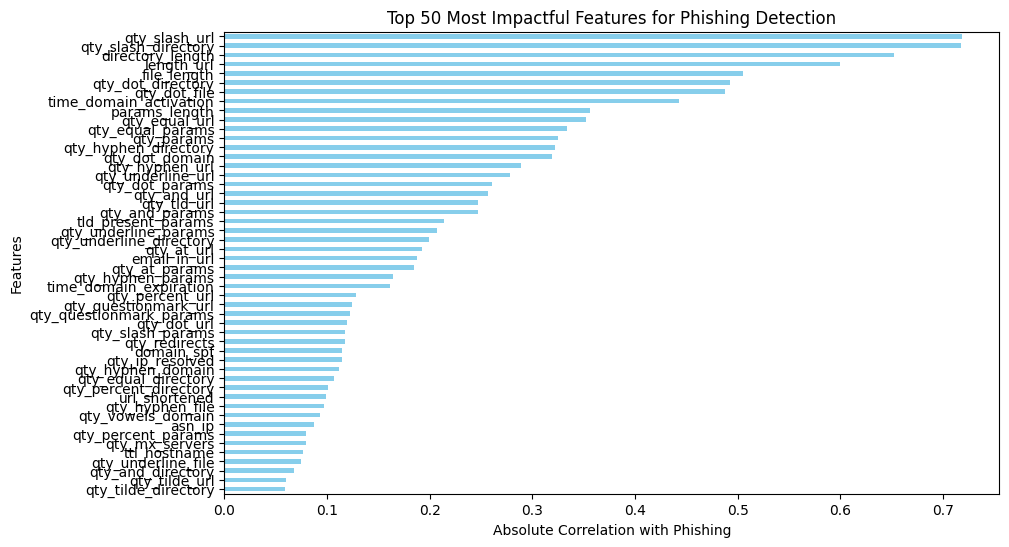

In [362]:
# Plot top 15 features
plt.figure(figsize=(10, 6))
top_50_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 50 Most Impactful Features for Phishing Detection')
plt.xlabel('Absolute Correlation with Phishing')
plt.ylabel('Features')
plt.show()

In [363]:
# List of important features for phishing detection
useful_columns=['qty_slash_url', 'length_url', 'qty_equal_url', 'qty_tld_url', 'qty_hyphen_url', 
                'qty_underline_url', 'qty_and_url', 'qty_dot_domain', 'qty_hyphen_domain', 'qty_vowels_domain', 
                'domain_in_ip', 'domain_length', 'qty_underline_domain', 'server_client_domain', 'qty_slash_directory', 
                'qty_questionmark_directory', 'qty_hashtag_directory', 'qty_exclamation_directory', 'qty_comma_directory', 
                'qty_tilde_directory', 'qty_space_directory', 'qty_at_file', 'qty_exclamation_file', 'qty_and_file', 
                'qty_asterisk_params', 'qty_tilde_params', 'qty_space_params', 'qty_dollar_params', 'qty_comma_params', 
                'qty_exclamation_params','phishing']

# Drop other columns from the DataFrame
df = df[useful_columns]

In [364]:
df.head()

,qty_slash_url,length_url,qty_equal_url,qty_tld_url,qty_hyphen_url,qty_underline_url,qty_and_url,qty_dot_domain,qty_hyphen_domain,qty_vowels_domain,...,qty_at_file,qty_exclamation_file,qty_and_file,qty_asterisk_params,qty_tilde_params,qty_space_params,qty_dollar_params,qty_comma_params,qty_exclamation_params,phishing
0,1.0,25.000000,0.000000,1.000000,0.0,0.000000,0.000000,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,36.354467,0.207618,1.047309,0.0,0.113773,0.142253,2.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,15.000000,0.000000,1.000000,0.0,0.000000,0.000000,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,81.000000,0.000000,1.000000,0.0,0.113773,0.000000,2.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,19.000000,0.000000,1.000000,0.0,0.000000,0.000000,2.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [365]:
df.describe(include='all')

,qty_slash_url,length_url,qty_equal_url,qty_tld_url,qty_hyphen_url,qty_underline_url,qty_and_url,qty_dot_domain,qty_hyphen_domain,qty_vowels_domain,...,qty_at_file,qty_exclamation_file,qty_and_file,qty_asterisk_params,qty_tilde_params,qty_space_params,qty_dollar_params,qty_comma_params,qty_exclamation_params,phishing
count,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,73770.000000,...,7.377000e+04,7.377000e+04,73770.000000,7.377000e+04,7.377000e+04,7.377000e+04,7.377000e+04,73770.000000,7.377000e+04,73770.000000
mean,1.194953,29.739952,0.017137,1.002224,0.184972,0.006880,0.006142,1.818562,0.010636,5.391432,...,9.298030e-08,9.132650e-07,0.000002,5.145155e-09,4.593888e-09,5.145155e-09,6.688702e-08,0.000002,1.657475e-07,0.345940
std,1.676234,19.875502,0.057134,0.010014,0.447082,0.027119,0.028913,0.567315,0.033431,2.371544,...,5.383413e-06,2.963361e-05,0.000055,6.987141e-07,5.579863e-07,6.987141e-07,5.038192e-06,0.000048,9.596518e-06,0.475677
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,0.000000,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
50%,0.000000,22.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,5.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
75%,2.000000,36.354467,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,7.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000
max,7.000000,118.000000,0.207618,1.047309,2.000000,0.113773,0.142253,3.000000,0.115711,15.000000,...,3.117799e-04,9.624509e-04,0.001464,9.488952e-05,6.777823e-05,9.488952e-05,3.795581e-04,0.001518,5.557815e-04,1.000000


In [366]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of qty_slash_url is : 1.4327511790278553
The skewness of length_url is : 1.8591059126502176
The skewness of qty_equal_url is : 3.0340781787690716
The skewness of qty_tld_url is : 4.280385661945408
The skewness of qty_hyphen_url is : 2.5280824492726945
The skewness of qty_underline_url is : 3.688030374354203
The skewness of qty_and_url is : 4.495290883581006
The skewness of qty_dot_domain is : -0.03166573861333783
The skewness of qty_hyphen_domain is : 2.8249737213746826
The skewness of qty_vowels_domain is : 0.538007788167416
The skewness of domain_in_ip is : 20.63770836207447
The skewness of domain_length is : 0.602728909720825
The skewness of qty_underline_domain is : 40.9103846009454
The skewness of server_client_domain is : 15.279268598889978
The skewness of qty_slash_directory is : 1.4323777760992638
The skewness of qty_questionmark_directory is : 0.0
The skewness of qty_hashtag_directory is : 0.0
The skewness of qty_exclamation_directory is : 28.738670803148693
The s

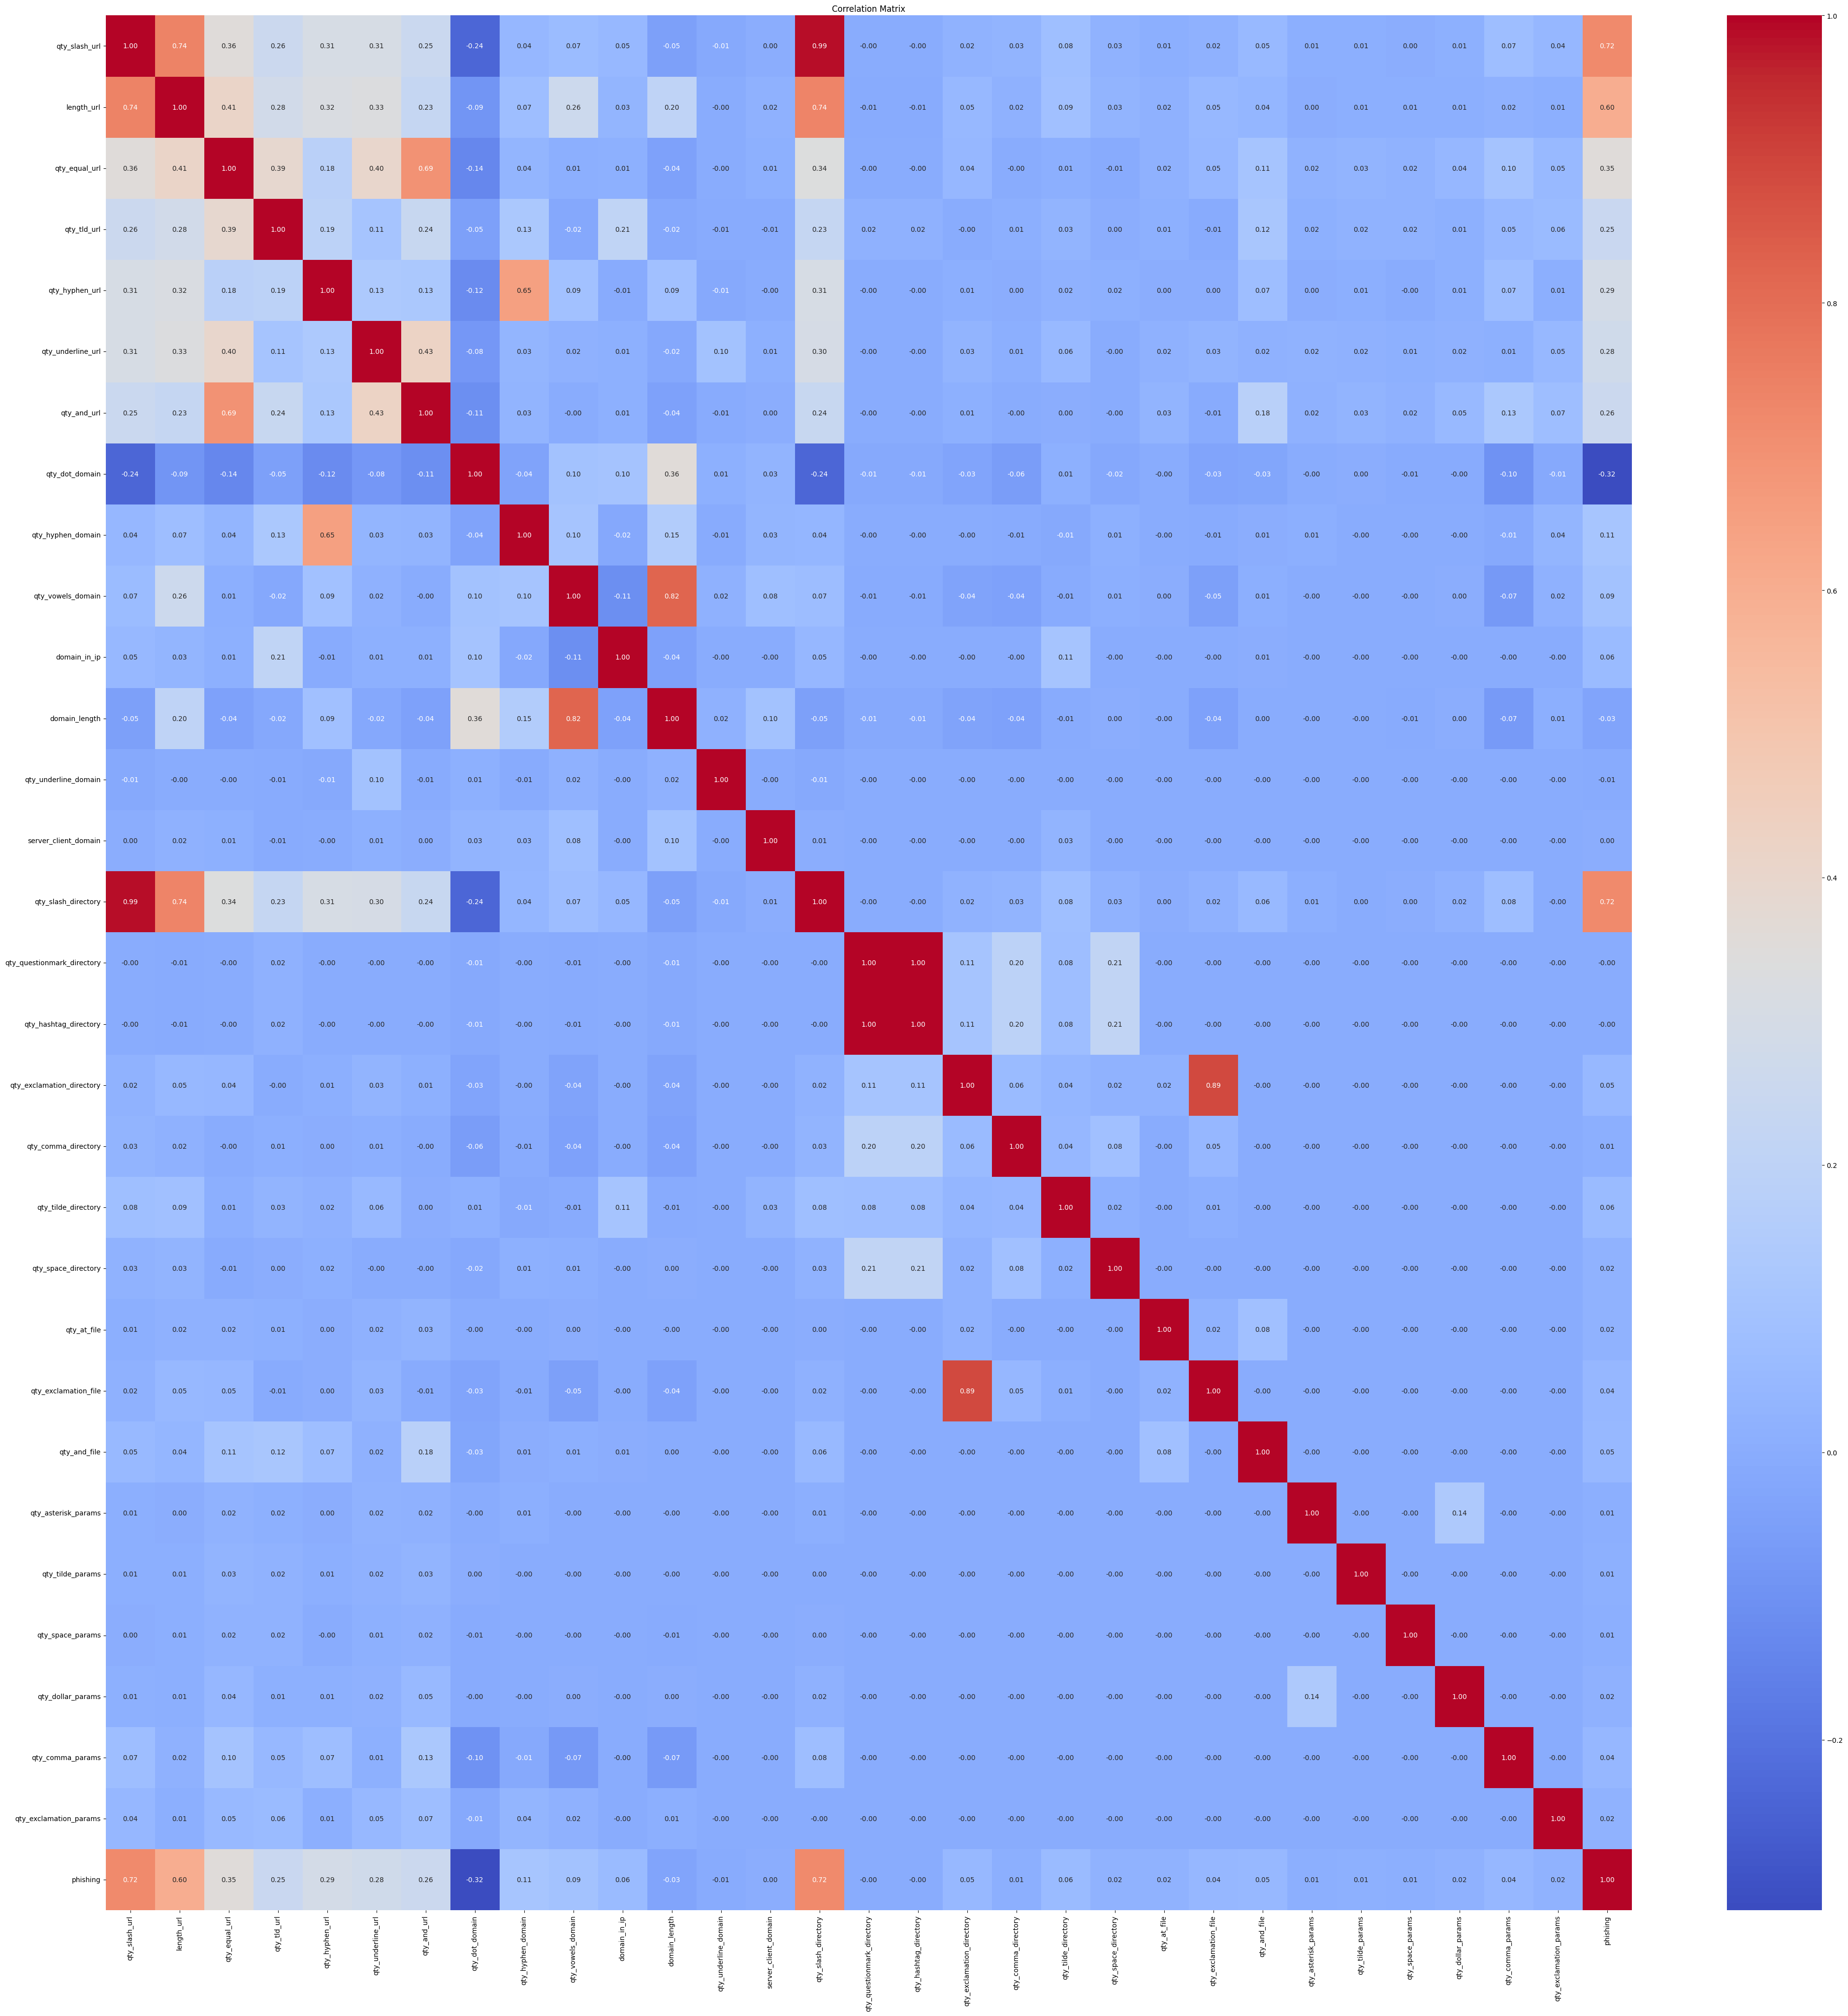

In [367]:
plt.figure(figsize=(50, 50))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [368]:
# Define batches (excluding runtime features)
batches = {
    'url_features1': ['qty_slash_url', 'length_url', 'qty_equal_url', 'qty_tld_url', 'qty_hyphen_url', 
                'qty_underline_url', 'qty_and_url', 'qty_dot_domain', 'qty_hyphen_domain', 'qty_vowels_domain', 
                'domain_in_ip', 'domain_length', 'qty_underline_domain', 'server_client_domain', 'qty_slash_directory', 
                'qty_questionmark_directory' ],
    
    'uomain_features2': ['qty_hashtag_directory', 'qty_exclamation_directory', 'qty_comma_directory', 
                'qty_tilde_directory', 'qty_space_directory', 'qty_at_file', 'qty_exclamation_file', 'qty_and_file', 
                'qty_asterisk_params', 'qty_tilde_params', 'qty_space_params', 'qty_dollar_params', 'qty_comma_params', 
                'qty_exclamation_params']
}


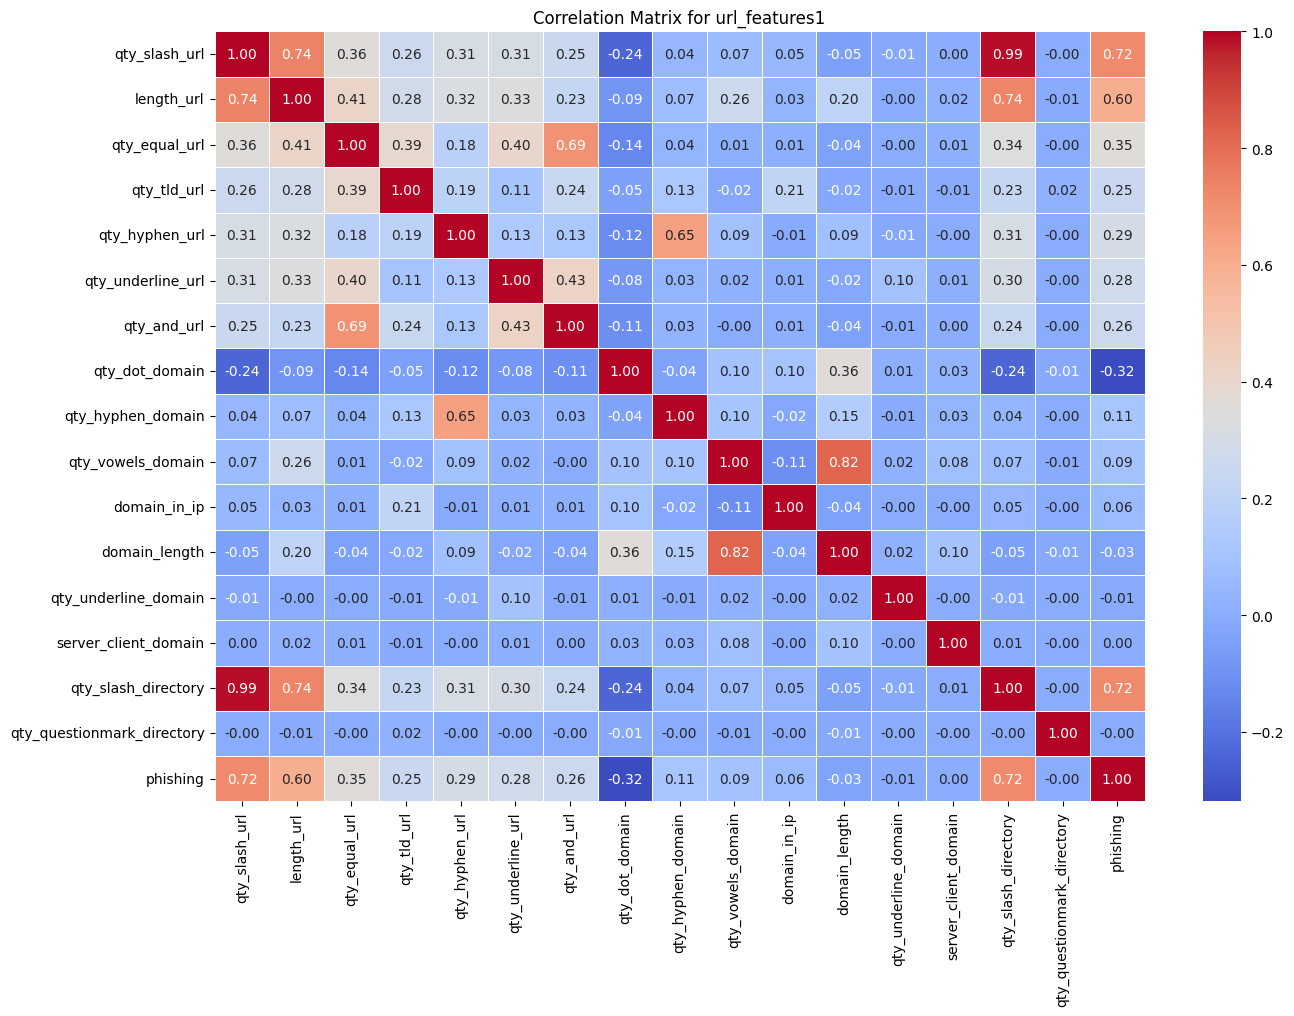

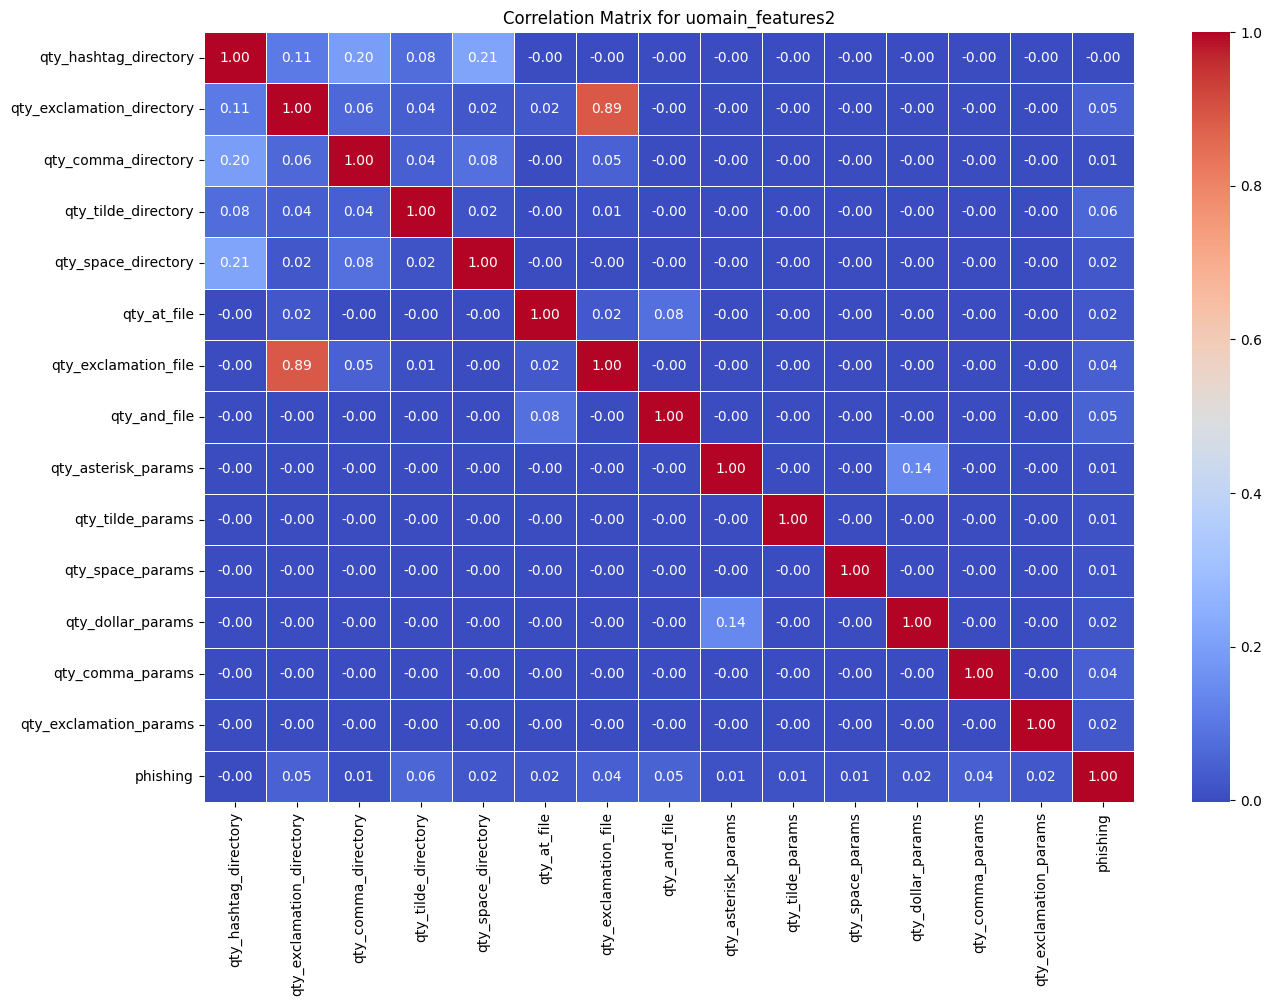

In [369]:
# Add 'phishing' to each batch
for batch_name, features in batches.items():
    features.append('phishing')

# Plot correlation matrix for each batch
for batch_name, features in batches.items():
    plt.figure(figsize=(15, 10))
    correlation_matrix = df[features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f'Correlation Matrix for {batch_name}')
    plt.show()

In [370]:
for skewness in df.columns:
    print(f"The skewness of {skewness} is : {df[skewness].skew()}")


The skewness of qty_slash_url is : 1.4327511790278553
The skewness of length_url is : 1.8591059126502176
The skewness of qty_equal_url is : 3.0340781787690716
The skewness of qty_tld_url is : 4.280385661945408
The skewness of qty_hyphen_url is : 2.5280824492726945
The skewness of qty_underline_url is : 3.688030374354203
The skewness of qty_and_url is : 4.495290883581006
The skewness of qty_dot_domain is : -0.03166573861333783
The skewness of qty_hyphen_domain is : 2.8249737213746826
The skewness of qty_vowels_domain is : 0.538007788167416
The skewness of domain_in_ip is : 20.63770836207447
The skewness of domain_length is : 0.602728909720825
The skewness of qty_underline_domain is : 40.9103846009454
The skewness of server_client_domain is : 15.279268598889978
The skewness of qty_slash_directory is : 1.4323777760992638
The skewness of qty_questionmark_directory is : 0.0
The skewness of qty_hashtag_directory is : 0.0
The skewness of qty_exclamation_directory is : 28.738670803148693
The s

In [371]:
df.head()

,qty_slash_url,length_url,qty_equal_url,qty_tld_url,qty_hyphen_url,qty_underline_url,qty_and_url,qty_dot_domain,qty_hyphen_domain,qty_vowels_domain,...,qty_at_file,qty_exclamation_file,qty_and_file,qty_asterisk_params,qty_tilde_params,qty_space_params,qty_dollar_params,qty_comma_params,qty_exclamation_params,phishing
0,1.0,25.000000,0.000000,1.000000,0.0,0.000000,0.000000,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,36.354467,0.207618,1.047309,0.0,0.113773,0.142253,2.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,15.000000,0.000000,1.000000,0.0,0.000000,0.000000,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,81.000000,0.000000,1.000000,0.0,0.113773,0.000000,2.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,19.000000,0.000000,1.000000,0.0,0.000000,0.000000,2.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [372]:
df.columns

Index(['qty_slash_url', 'length_url', 'qty_equal_url', 'qty_tld_url',
       'qty_hyphen_url', 'qty_underline_url', 'qty_and_url', 'qty_dot_domain',
       'qty_hyphen_domain', 'qty_vowels_domain', 'domain_in_ip',
       'domain_length', 'qty_underline_domain', 'server_client_domain',
       'qty_slash_directory', 'qty_questionmark_directory',
       'qty_hashtag_directory', 'qty_exclamation_directory',
       'qty_comma_directory', 'qty_tilde_directory', 'qty_space_directory',
       'qty_at_file', 'qty_exclamation_file', 'qty_and_file',
       'qty_asterisk_params', 'qty_tilde_params', 'qty_space_params',
       'qty_dollar_params', 'qty_comma_params', 'qty_exclamation_params',
       'phishing'],
      dtype='object')

In [373]:

# Creating holders to store the model performance results
ML_Model = []
accuracy = []
f1_score = []
recall = []
precision = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
  ML_Model.append(model)
  accuracy.append(round(a, 3))
  f1_score.append(round(b, 3))
  recall.append(round(c, 3))
  precision.append(round(d, 3))

In [374]:
X = df.drop(columns=['phishing'])  # Features (all columns except 'phishing')
y = df['phishing']  # Target (only the 'phishing' column)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  
    random_state=42  
)

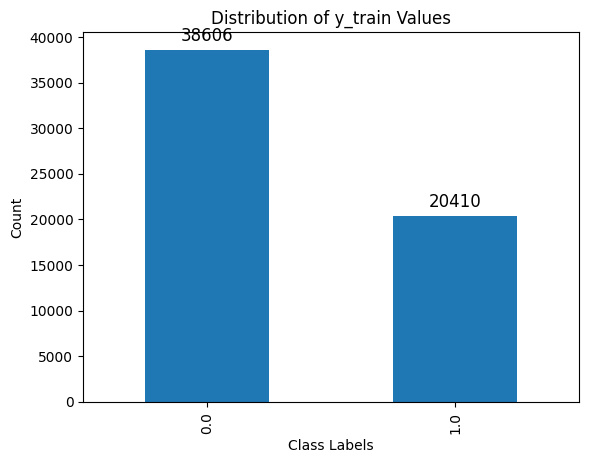

In [375]:
#histogram for training dataset showing o. of phising and non phishing 
ax = y_train.value_counts().plot(kind='bar')

# Display count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 10), textcoords='offset points')

# Label the graph
plt.title('Distribution of y_train Values')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.show()

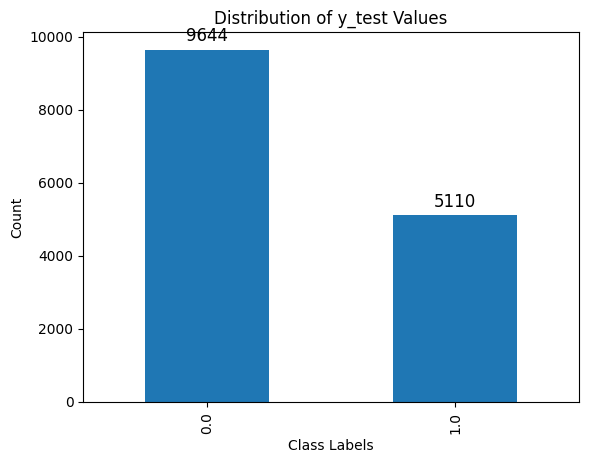

In [376]:
#histogram for training dataset showing o. of phising and non phishing 
ax = y_test.value_counts().plot(kind='bar')

# Display count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 10), textcoords='offset points')

# Label the graph
plt.title('Distribution of y_test Values')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.show()
plt.show()

In [377]:
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (59016, 30)
X_test shape: (14754, 30)
y_train shape: (59016,)
y_test shape: (14754,)


In [378]:
# # Lists to store accuracy
# n_estimators = [10, 50, 100, 150, 200]
# train_accuracies = []
# test_accuracies = []

# # Train Random Forest with varying number of trees
# for n in n_estimators:
#     rf = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42, bootstrap=True)
#     rf.fit(x_train, y_train)
    
#     # Accuracy on training and test sets
#     train_acc = accuracy_score(y_train, rf.predict(x_train))
#     test_acc = accuracy_score(y_test, rf.predict(x_test))
    
#     train_accuracies.append(train_acc)
#     test_accuracies.append(test_acc)

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.plot(n_estimators, train_accuracies, label='Training Accuracy', marker='o')
# plt.plot(n_estimators, test_accuracies, label='Testing Accuracy', marker='s')
# plt.xlabel('Number of Trees')
# plt.ylabel('Accuracy')
# plt.title('Random Forest Training vs Testing Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [379]:
training_accuracy_rf = []
test_accuracy_rf = []

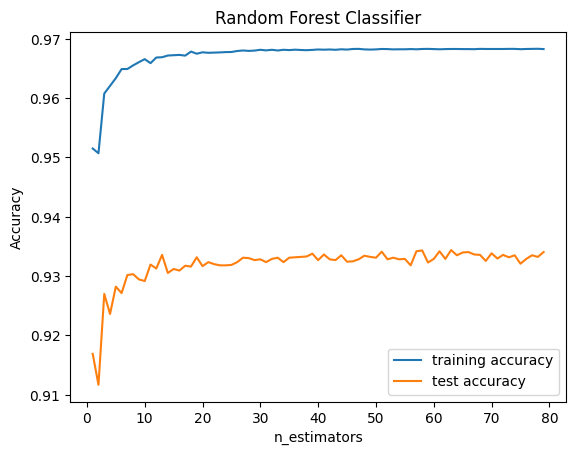

In [380]:
depth = range(1,80)
for n in depth:
    forest_test =  RandomForestClassifier(n_estimators=n)

    forest_test.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy_rf.append(forest_test.score(x_train, y_train))
    # record generalization accuracy
    test_accuracy_rf.append(forest_test.score(x_test, y_test))


#plotting the training & testing accuracy for n_estimators from 1 to 20
plt.figure(figsize=None)
plt.plot(depth, training_accuracy_rf, label="training accuracy")
plt.plot(depth, test_accuracy_rf, label="test accuracy")
plt.title("Random Forest Classifier")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.legend()

In [381]:
RF=RandomForestClassifier(n_estimators=150,random_state=42)
RF_Model=RF.fit(x_train,y_train)

In [382]:
y_test.shape

(14754,)

In [383]:
y_pred=RF_Model.predict(x_test)

In [384]:
y_train_forest = RF_Model.predict(x_train)

In [385]:
y_pred.shape

(14754,)

In [386]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC Score
roc_auc = auc(fpr, tpr)

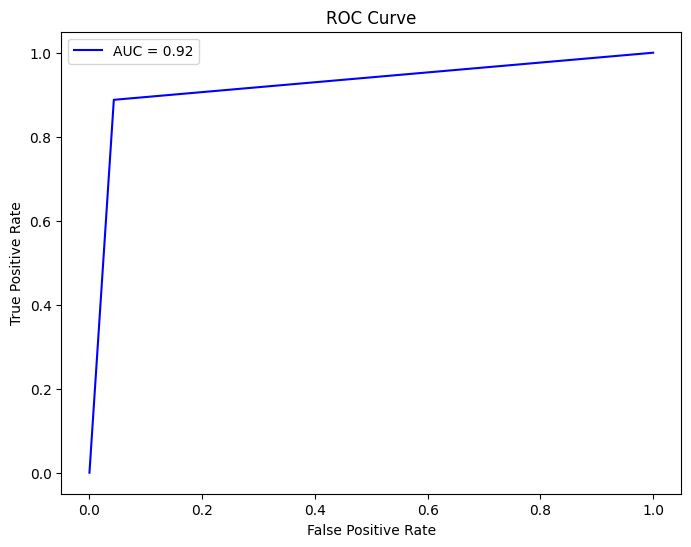

In [387]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [388]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      9644
         1.0       0.92      0.89      0.90      5110

    accuracy                           0.93     14754
   macro avg       0.93      0.92      0.93     14754
weighted avg       0.93      0.93      0.93     14754



In [389]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_forest = metrics.accuracy_score(y_train,y_train_forest)
acc_test_forest = metrics.accuracy_score(y_test,y_pred)
print("Random Forest : Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random Forest : Accuracy on test Data: {:.3f}".format(acc_test_forest))
print()

f1_score_train_forest = metrics.f1_score(y_train,y_train_forest)
f1_score_test_forest = metrics.f1_score(y_test,y_pred)
print("Random Forest : f1_score on training Data: {:.3f}".format(f1_score_train_forest))
print("Random Forest : f1_score on test Data: {:.3f}".format(f1_score_test_forest))
print()

recall_score_train_forest = metrics.recall_score(y_train,y_train_forest)
recall_score_test_forest = metrics.recall_score(y_test,y_pred)
print("Random Forest : Recall on training Data: {:.3f}".format(recall_score_train_forest))
print("Random Forest : Recall on test Data: {:.3f}".format(recall_score_test_forest))
print()

precision_score_train_forest = metrics.precision_score(y_train,y_train_forest)
precision_score_test_forest = metrics.precision_score(y_test,y_pred)
print("Random Forest : precision on training Data: {:.3f}".format(precision_score_train_forest))
print("Random Forest : precision on test Data: {:.3f}".format(precision_score_test_forest))

Random Forest : Accuracy on training Data: 0.968
Random Forest : Accuracy on test Data: 0.933

Random Forest : f1_score on training Data: 0.953
Random Forest : f1_score on test Data: 0.902

Random Forest : Recall on training Data: 0.929
Random Forest : Recall on test Data: 0.888

Random Forest : precision on training Data: 0.979
Random Forest : precision on test Data: 0.916


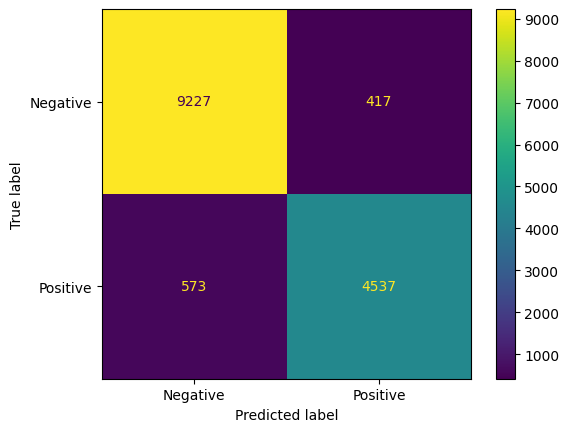

In [390]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

In [391]:
with open("phishing_detection_model.pkl", "wb") as file:
    pickle.dump(RF_Model, file)
print("Model saved successfully!")

Model saved successfully!


In [392]:
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(n_estimators=100,random_state=42)

# fit the model 
XG_Model= xgb.fit(x_train,y_train)

In [393]:

#predicting the target value from the model for the samples
y_train_xgb = XG_Model.predict(x_train)
y_test_xgb = XG_Model.predict(x_test)

In [394]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_test_xgb)
#Calculate AUC score
roc_auc1 = auc(fpr1, tpr1)

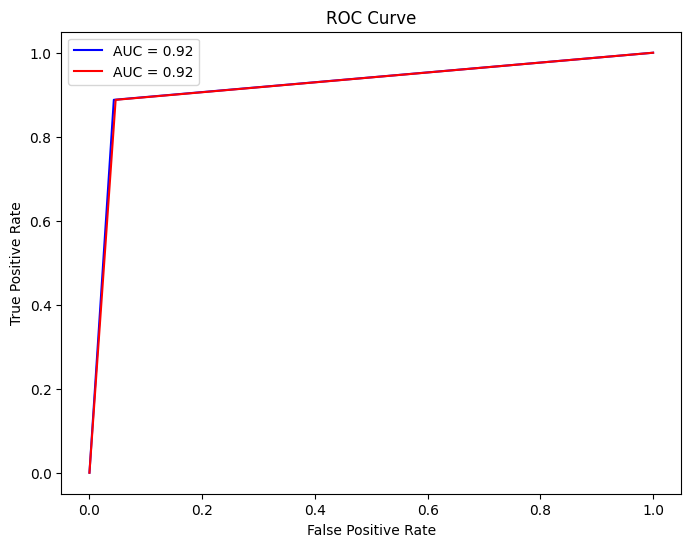

In [395]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot(fpr1, tpr1, color='red', label=f'AUC = {roc_auc1:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [396]:
report = classification_report(y_test, y_test_xgb)

print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      9644
         1.0       0.91      0.89      0.90      5110

    accuracy                           0.93     14754
   macro avg       0.93      0.92      0.92     14754
weighted avg       0.93      0.93      0.93     14754



In [397]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_xgb = metrics.accuracy_score(y_train,y_train_xgb)
acc_test_xgb = metrics.accuracy_score(y_test,y_test_xgb)
print("XGBoost Classifier : Accuracy on training Data: {:.3f}".format(acc_train_xgb))
print("XGBoost Classifier : Accuracy on test Data: {:.3f}".format(acc_test_xgb))
print()

f1_score_train_xgb = metrics.f1_score(y_train,y_train_xgb)
f1_score_test_xgb = metrics.f1_score(y_test,y_test_xgb)
print("XGBoost Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_xgb))
print("XGBoost Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_xgb))
print()

recall_score_train_xgb = metrics.recall_score(y_train,y_train_xgb)
recall_score_test_xgb = metrics.recall_score(y_test,y_test_xgb)
print("XGBoost Classifier : Recall on training Data: {:.3f}".format(recall_score_train_xgb))
print("XGBoost Classifier : Recall on test Data: {:.3f}".format(recall_score_train_xgb))
print()

precision_score_train_xgb = metrics.precision_score(y_train,y_train_xgb)
precision_score_test_xgb = metrics.precision_score(y_test,y_test_xgb)
print("XGBoost Classifier : precision on training Data: {:.3f}".format(precision_score_train_xgb))
print("XGBoost Classifier : precision on test Data: {:.3f}".format(precision_score_test_xgb))

XGBoost Classifier : Accuracy on training Data: 0.941
XGBoost Classifier : Accuracy on test Data: 0.931

XGBoost Classifier : f1_score on training Data: 0.913
XGBoost Classifier : f1_score on test Data: 0.899

XGBoost Classifier : Recall on training Data: 0.902
XGBoost Classifier : Recall on test Data: 0.902

XGBoost Classifier : precision on training Data: 0.924
XGBoost Classifier : precision on test Data: 0.910


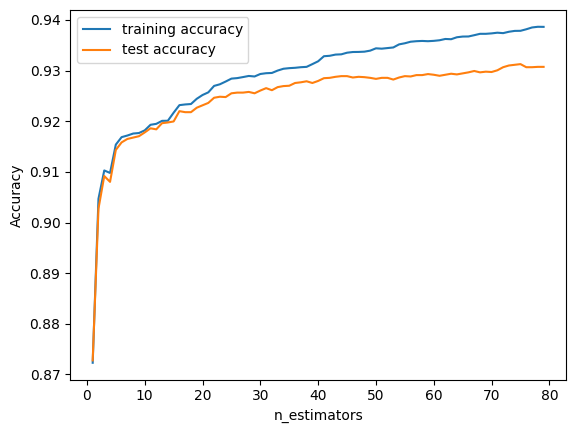

In [398]:
training_accuracy_xgb = []
test_accuracy_xgb= []
# try max_depth from 1 to 20
depth = range(1,80)
for n in depth:
    xgb_test =  XGBClassifier(n_estimators=n)

    xgb_test.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy_xgb.append(xgb_test.score(x_train, y_train))
    # record generalization accuracy
    test_accuracy_xgb.append(xgb_test.score(x_test, y_test))
    

#plotting the training & testing accuracy for n_estimators from 1 to 20
plt.figure(figsize=None)
plt.plot(depth, training_accuracy_xgb, label="training accuracy")
plt.plot(depth, test_accuracy_xgb, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("n_estimators")
plt.legend()

In [399]:

#storing the results. The below mentioned order of parameter passing is important.

storeResults('Random Forest',acc_test_forest,f1_score_test_forest,
             recall_score_train_forest,precision_score_train_forest)

In [400]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('XGBoost Classifier',acc_test_xgb,f1_score_test_xgb,
             recall_score_train_xgb,precision_score_train_xgb)

In [401]:
# Train model using naive bayes classifier
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
NB_Model = nb.fit(x_train, y_train)


In [402]:
#predicting the target value from the model for the samples
y_train_naive = nb.predict(x_train)
y_test_naive = nb.predict(x_test)


In [403]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_test_naive)
#Calculate AUC score
roc_auc2 = auc(fpr2, tpr2)

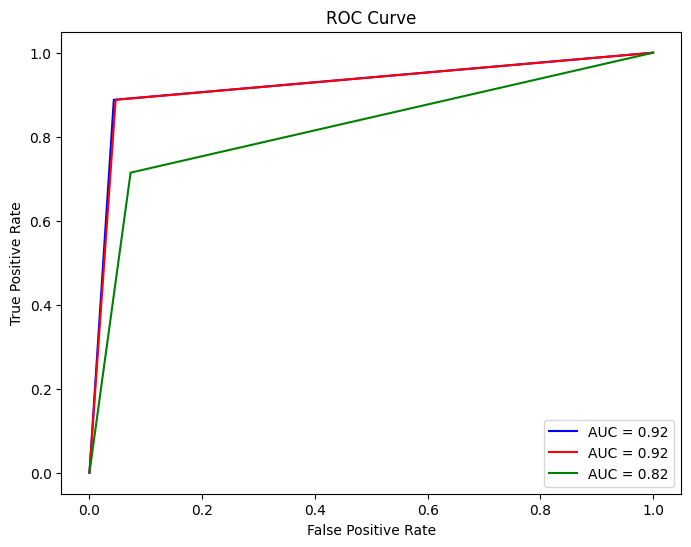

In [404]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot(fpr1, tpr1, color='red', label=f'AUC = {roc_auc1:.2f}')
plt.plot(fpr2, tpr2, color='green', label=f'AUC = {roc_auc2:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

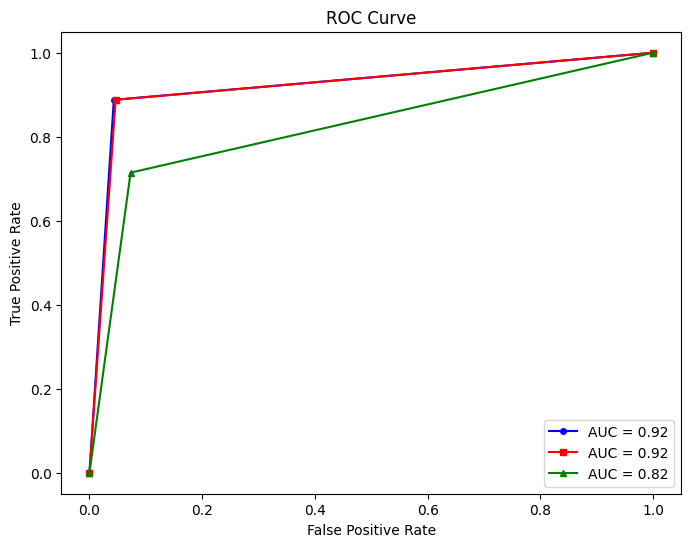

In [405]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', marker='o', markersize=4, label=f'AUC = {roc_auc:.2f}')  # Circle markers
plt.plot(fpr1, tpr1, color='red', marker='s', markersize=4, label=f'AUC = {roc_auc1:.2f}')  # Square markers
plt.plot(fpr2, tpr2, color='green', marker='^', markersize=4, label=f'AUC = {roc_auc2:.2f}')  # Triangle markers
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [406]:
report = classification_report(y_test, y_test_naive)

print(report)

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      9644
         1.0       0.84      0.71      0.77      5110

    accuracy                           0.85     14754
   macro avg       0.85      0.82      0.83     14754
weighted avg       0.85      0.85      0.85     14754



In [407]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_naive = metrics.accuracy_score(y_train,y_train_naive)
acc_test_naive = metrics.accuracy_score(y_test,y_test_naive)
print("Naive Bayes Classifier : Accuracy on training Data: {:.3f}".format(acc_train_naive))
print("Naive Bayes Classifier : Accuracy on test Data: {:.3f}".format(acc_test_naive))
print()

f1_score_train_naive = metrics.f1_score(y_train,y_train_naive)
f1_score_test_naive = metrics.f1_score(y_test,y_test_naive)
print("Naive Bayes Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_naive))
print("Naive Bayes Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_naive))
print()

recall_score_train_naive = metrics.recall_score(y_train,y_train_naive)
recall_score_test_naive = metrics.recall_score(y_test,y_test_naive)
print("Naive Bayes Classifier : Recall on training Data: {:.3f}".format(recall_score_train_naive))
print("Naive Bayes Classifier : Recall on test Data: {:.3f}".format(recall_score_train_naive))
print()

precision_score_train_naive = metrics.precision_score(y_train,y_train_naive)
precision_score_test_naive = metrics.precision_score(y_test,y_test_naive)
print("Naive Bayes Classifier : precision on training Data: {:.3f}".format(precision_score_train_naive))
print("Naive Bayes Classifier : precision on test Data: {:.3f}".format(precision_score_train_naive))

Naive Bayes Classifier : Accuracy on training Data: 0.855
Naive Bayes Classifier : Accuracy on test Data: 0.853

Naive Bayes Classifier : f1_score on training Data: 0.772
Naive Bayes Classifier : f1_score on test Data: 0.771

Naive Bayes Classifier : Recall on training Data: 0.711
Naive Bayes Classifier : Recall on test Data: 0.711

Naive Bayes Classifier : precision on training Data: 0.844
Naive Bayes Classifier : precision on test Data: 0.844


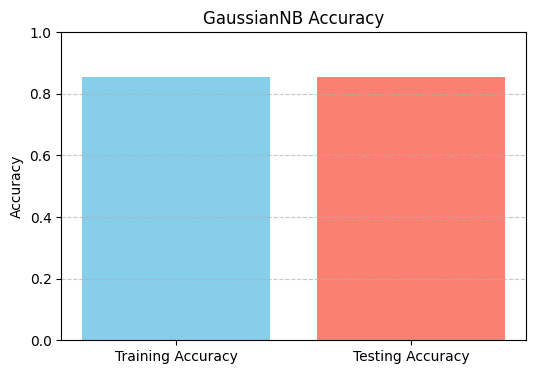

In [408]:
# Initialize lists for accuracies
training_accuracy_nb = []
test_accuracy_nb = []

gaussian_test = GaussianNB()

# Fit the model
gaussian_test.fit(x_train, y_train)

# Record training accuracy
training_accuracy_nb.append(gaussian_test.score(x_train, y_train))

# Record test accuracy
test_accuracy_nb.append(gaussian_test.score(x_test, y_test))

train_accuracy_gnb = accuracy_score(y_train, y_train_naive)
test_accuracy_gnb = accuracy_score(y_test, y_test_naive)
# Plotting the training & testing accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_accuracy_gnb, test_accuracy_gnb], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.title('GaussianNB Accuracy')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [409]:
train_accuracy_gnb=[0.8546326419953911]
test_accuracy_gnb=[0.8533956893045954]

In [410]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('Naive Bayes Classifier',acc_test_naive,f1_score_test_naive,
             recall_score_train_naive,precision_score_train_naive)

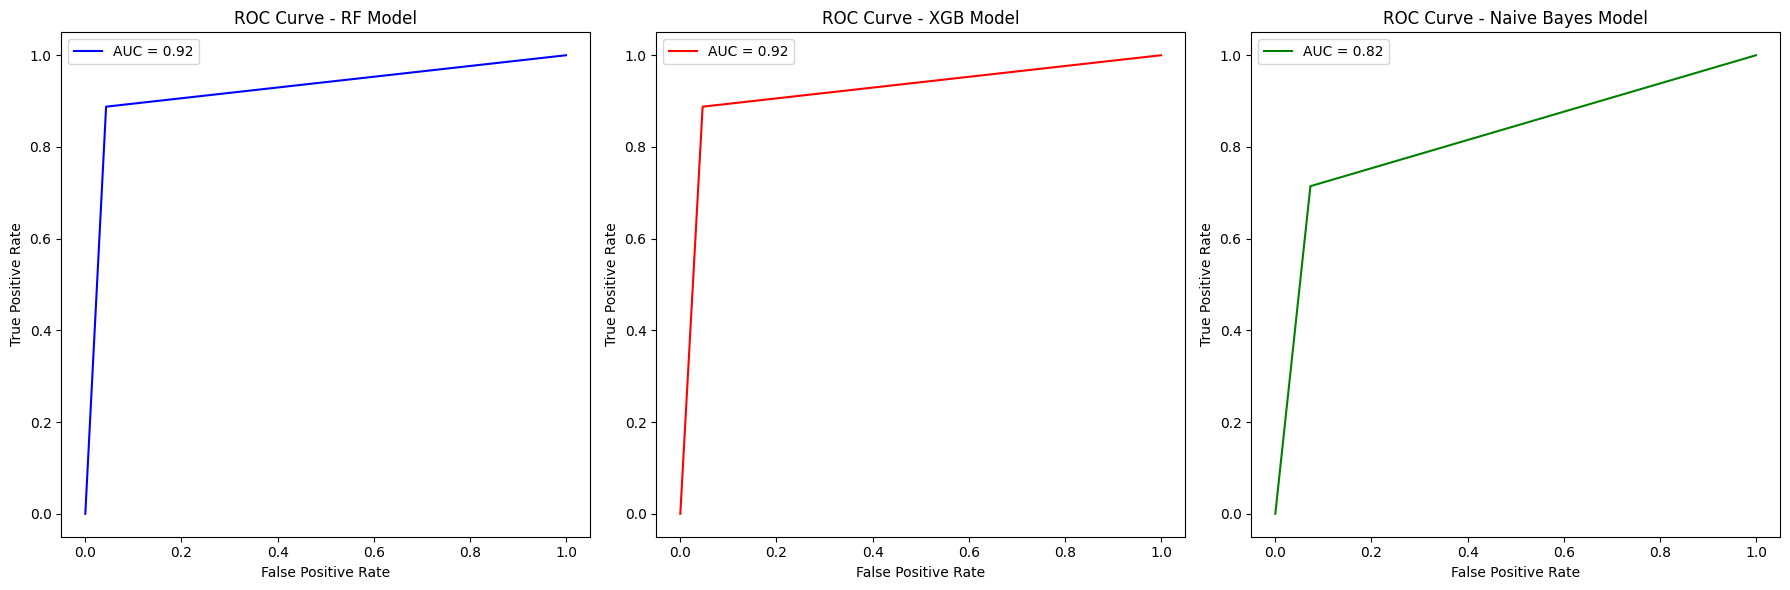

In [411]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the first ROC curve
axes[0].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axes[0].set_title('ROC Curve - RF Model')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

# Plot the second ROC curve
axes[1].plot(fpr1, tpr1, color='red', label=f'AUC = {roc_auc1:.2f}')
axes[1].set_title('ROC Curve - XGB Model')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

# Plot the third ROC curve
axes[2].plot(fpr2, tpr2, color='green', label=f'AUC = {roc_auc2:.2f}')
axes[2].set_title('ROC Curve - Naive Bayes Model')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [412]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)

In [413]:
Decision_tree_model=dtree.fit(x_train,y_train)
y_pred_decision=Decision_tree_model.predict(x_test)
y_train_decision= Decision_tree_model.predict(x_train)

In [414]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_decision)
#Calculate AUC score
roc_auc3 = auc(fpr3, tpr3)

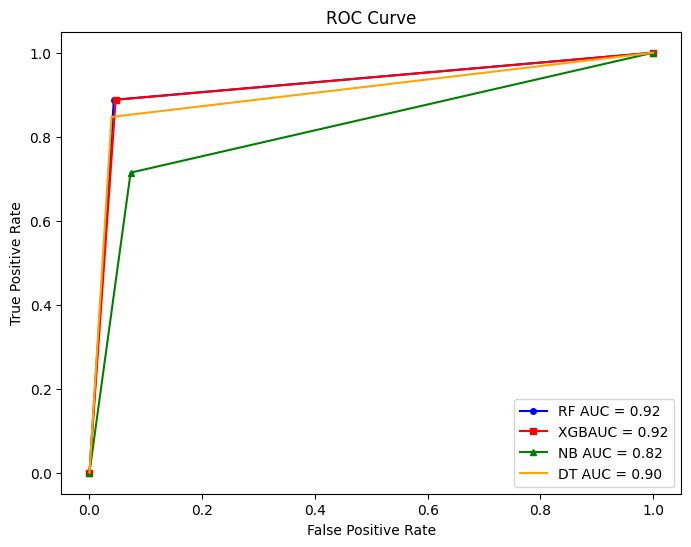

In [415]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', marker='o', markersize=4, label=f'RF AUC = {roc_auc:.2f}')  # Circle markers
plt.plot(fpr1, tpr1, color='red', marker='s', markersize=4, label=f'XGBAUC = {roc_auc1:.2f}')  # Square markers
plt.plot(fpr2, tpr2, color='green', marker='^', markersize=4, label=f'NB AUC = {roc_auc2:.2f}')  # Triangle markers
plt.plot(fpr3, tpr3, color='orange', markersize=4, label=f'DT AUC = {roc_auc3:.2f}') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [416]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_dt = metrics.accuracy_score(y_train,y_train_decision)
acc_test_dt = metrics.accuracy_score(y_test,y_pred_decision)
print("DT classifier: Accuracy on training Data: {:.3f}".format(acc_train_dt))
print("XGBoost Classifier : Accuracy on test Data: {:.3f}".format(acc_test_dt))
print()

f1_score_train_dt = metrics.f1_score(y_train,y_train_decision)
f1_score_test_dt = metrics.f1_score(y_test,y_pred_decision)
print("DT Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_dt))
print("DT Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_dt))
print()

recall_score_train_dt = metrics.recall_score(y_train,y_train_decision)
recall_score_test_dt = metrics.recall_score(y_test,y_pred_decision)
print("DT Classifier : Recall on training Data: {:.3f}".format(recall_score_train_dt))
print("DT Classifier : Recall on test Data: {:.3f}".format(recall_score_train_dt))
print()

precision_score_train_dt = metrics.precision_score(y_train,y_train_decision)
precision_score_test_dt = metrics.precision_score(y_test,y_pred_decision)
print("DT Classifier : precision on training Data: {:.3f}".format(precision_score_train_dt))
print("DT Classifier : precision on test Data: {:.3f}".format(precision_score_test_dt))

DT classifier: Accuracy on training Data: 0.968
XGBoost Classifier : Accuracy on test Data: 0.921

DT Classifier : f1_score on training Data: 0.953
DT Classifier : f1_score on test Data: 0.882

DT Classifier : Recall on training Data: 0.921
DT Classifier : Recall on test Data: 0.921

DT Classifier : precision on training Data: 0.986
DT Classifier : precision on test Data: 0.920


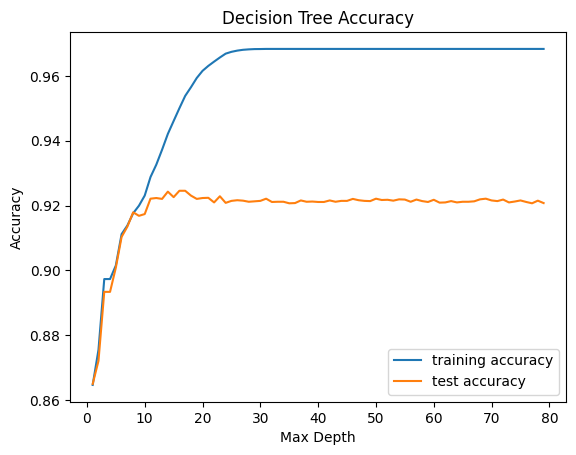

In [417]:
training_accuracy_dt = []
test_accuracy_dt = []
depth = range(1,80)
for n in depth:
    decision_test =  DecisionTreeClassifier(max_depth=n)

    decision_test.fit(x_train, y_train)
    # record training set accuracy
    training_accuracy_dt.append(decision_test.score(x_train, y_train))
    # record generalization accuracy
    test_accuracy_dt.append(decision_test.score(x_test, y_test))


#plotting the training & testing accuracy for n_estimators from 1 to 20
plt.figure(figsize=None)
plt.plot(depth, training_accuracy_dt, label="training accuracy")
plt.plot(depth, test_accuracy_dt, label="test accuracy")
plt.title("Decision Tree Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.legend()

In [418]:
report = classification_report(y_test, y_pred_decision)

print(report)

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      9644
         1.0       0.92      0.85      0.88      5110

    accuracy                           0.92     14754
   macro avg       0.92      0.90      0.91     14754
weighted avg       0.92      0.92      0.92     14754



In [419]:
storeResults('Decision Tree Classifier',acc_test_dt,f1_score_test_dt,
             recall_score_train_dt,precision_score_train_dt)

In [420]:

#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'f1_score' : f1_score,
                        'Recall'   : recall,
                        'Precision': precision,
                      })

In [421]:
result

,ML Model,Accuracy,f1_score,Recall,Precision
0,Random Forest,0.933,0.902,0.929,0.979
1,XGBoost Classifier,0.931,0.899,0.902,0.924
2,Naive Bayes Classifier,0.853,0.771,0.711,0.844
3,Decision Tree Classifier,0.921,0.882,0.921,0.986


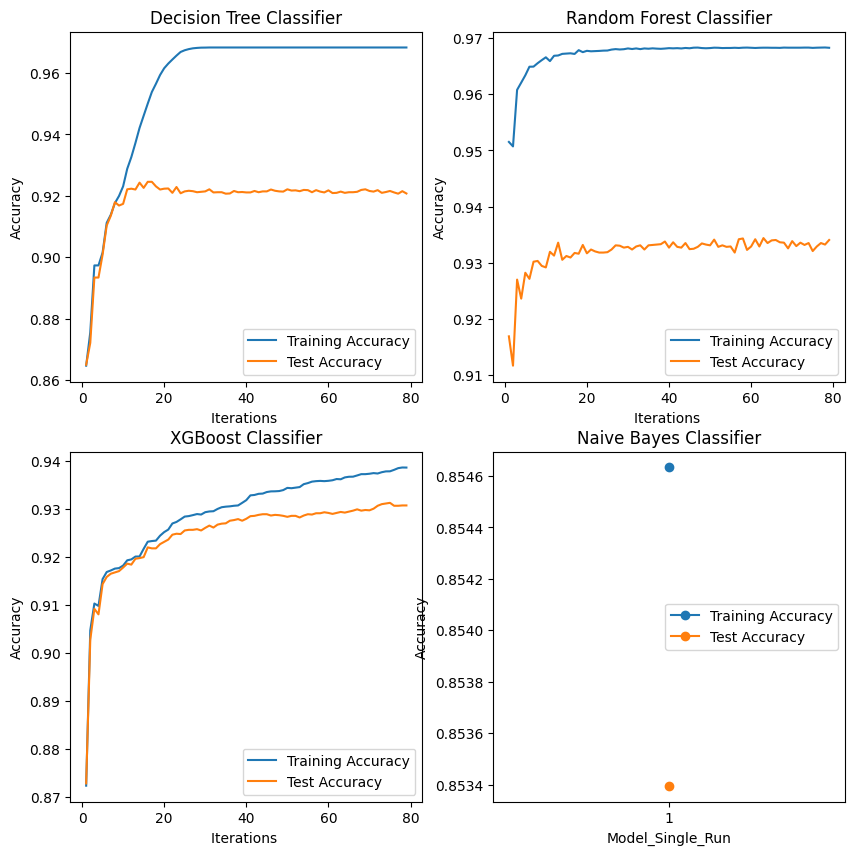

In [422]:
#subplot of training & testing accuracy of decisiontree,xgboost,naive bayes and random forest
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(depth, training_accuracy_dt, label="Training Accuracy")
ax[0, 0].plot(depth, test_accuracy_dt, label="Test Accuracy")
ax[0, 0].set_title("Decision Tree Classifier")
ax[0, 0].set_ylabel("Accuracy")
ax[0, 0].set_xlabel("Iterations ")
ax[0, 0].legend()
ax[0, 1].plot(depth, training_accuracy_rf, label="Training Accuracy")
ax[0, 1].plot(depth, test_accuracy_rf, label="Test Accuracy")
ax[0, 1].set_title("Random Forest Classifier")
ax[0, 1].set_ylabel("Accuracy")
ax[0, 1].set_xlabel("Iterations ")
ax[0, 1].legend()
ax[1, 0].plot(depth, training_accuracy_xgb, label="Training Accuracy")
ax[1, 0].plot(depth, test_accuracy_xgb, label="Test Accuracy")
ax[1, 0].set_title("XGBoost Classifier")
ax[1, 0].set_ylabel("Accuracy")
ax[1, 0].set_xlabel("Iterations ")
ax[1, 0].legend()
# Plot with dummy x-axis
ax[1, 1].plot([1], train_accuracy_gnb, label="Training Accuracy", marker='o')
ax[1, 1].plot([1], test_accuracy_gnb, label="Test Accuracy", marker='o')
ax[1, 1].set_title("Naive Bayes Classifier")
ax[1, 1].set_ylabel("Accuracy")
ax[1, 1].set_xlabel("Model_Single_Run")
ax[1, 1].set_xticks([1])
ax[1, 1].legend()
training_accuracy_dt = []
test_accuracy_dt = []